# Эксперименты с данными для проверки адекватности модели

## Введение

ИСПОЛЬЗУЕМЫЕ БИБЛИОТЕКИ

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
import math

ФУНКЦИЯ ПОЛУЧЕНИЯ РЯДОВ ИЗМЕРЕНИЙ

In [202]:
def create_z(y):
    res = []
    for j in range(4):
        zn = []
        for i in range(100):
            zn.append(y[0][i] - y[j][i])
        res.append(zn)
    return res

ЗАГРУЗКА EXCEL ФАЙЛА

In [203]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ИСТИННЫЕ РЯДЫ

In [204]:
file = '/content/drive/MyDrive/Colab Notebooks/DIPLOM/MAC_EXP.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('YA')
df.head(100)
YA = []
for i in range(4):
  YA.append(df['YA_' + str(i + 1)])

ИСХОДНЫЕ ДАННЫЕ

In [205]:
Sigma = 0.1
Ks = 3

Y_0 = np.transpose([-0.03349, -3.57923, 0.22813, -0.24162])
Ar = np.transpose([0.49919369, 0.9404525, 0.4547725086, 0.841137265])
SRm = np.transpose([0.52456, 0.56574, 0.74911, 0.50681])
SR_Sum = np.transpose([29.16337, 19.59779, 48.62246, 15.964]) # SR_Sum[j] = SR1[1] + SR1[j]

RegC = [[-0.003740645, 0, -0.249283006, -0.0212369],
        [0.044859474, 0, -0.098291637, 0.061969925],
        [0, 0, 0, 0]]
Step_y = np.transpose([0, 0, 0, 0]) # Ступенчатые функции на начало


def AR1(fi, r):
    return r * fi


def Reg(a, b, c, x):
    return a + b * x + c * (x ** 2)

ДАННЫЕ ДЛЯ РАСЧЁТА ОЦЕНКИ ТОЧНОСТИ ПРОГНОЗИРУЮЩИХ МОДЕЛЕЙ

In [206]:
def est(X, Y0, count):
    ep = []
    for k in range(4):
        e = 0
        for i in range(count):
            e += (Y0[i][k] - X[i][k])**2
        ep.append(e)
    return ep

In [207]:
dft = xl.parse('Tr')
dft.head(100)
Tr = []
for i in range(4):
  Tr.append(dft['Tr_' + str(i + 1)])
TR = np.transpose(Tr)

dfs = xl.parse('StY')
dfs.head(100)
St = []
for i in range(4):
  St.append(dfs['St_' + str(i + 1)])
ST = np.transpose(St)

ФУНКЦИЯ ДИНАМИЧЕСКОЙ ОБРАБОТКИ ЧАСТОТНО-ВРЕМЕННЫХ ДАННЫХ

In [208]:
def dynFilZ(X, sigma1, sigma2, count, n):  # ВСЁ ЕЩЁ НУЖНО ОТРЕДАКТИРОВАТЬ (гибкость в выборе количества генераторов) !!!
    If = []
    Lf = []
    z = []
    zch = []
    yp_m = []
    yp_st = []
    yp_t = []
    zp_st = []
    yp = []
    zp_t = []
    y = []
    Lambda = []
    alpha = []
    Beta = []
    BETA1 = []
    BETA2 = []
    BETA3 = []
    ya = np.transpose(YA)
    est_yp = []
    est_y = []
    MAIN_ARRAY = []
    e_yp_p = np.transpose([0., 0., 0., 0.]) # изменить
    g1 = []
    for i in range(n):
      g1.append(math.sqrt(sigma2[i]/2))
    g = []
    for i in range(n):
      part = 0
      for j in range(n):
        part += g1[j]
      g.append((g1[i]/part))

    s0 = []
    for i in range(n):
      s0.append(((sigma2[i]/2)*(count-2)))
    for s in range(count):
        Ip = np.transpose([1, 1, 1, 1]) # изменить
        Lp = np.transpose([1, 1, 1, 1]) # изменить
        deltaZ = np.transpose([0., 0., 0., 0.]) # изменить
        dyst = np.transpose([0., 0., 0., 0.]) # изменить
        dy = np.transpose([0., 0., 0., 0.]) # изменить

        yp_m_p = []
        yp_st_p = []
        yp_t_p = []
        yp_p = []
        zp_t_p = []
        for k in range(n):
            if s == 0:
                yp_m_p.append(AR1(Ar[k], Y_0[k]))
                yp_st_p.append(Step_y[k])
            else:
                yp_m_p.append(AR1(Ar[k], y[s-1][k]))
                yp_st_p.append(yp_st[s - 1][k])
                deltaZ[k] = X[s][k] - X[s - 1][k]
                if abs(deltaZ[k]) > (sigma1[k] * 6):
                    X[s][k] = X[s - 1][k]
                    print("Такт выброса: ", s)
                    print("Генератор выброса: ", k)
                    Ip[k] = 0
                    deltaZ[k] = 0
                if abs(deltaZ[k]) > (sigma2[k] * 3):
                    Lp[k] = 0
            yp_t_p.append(Reg(RegC[0][k], RegC[1][k], RegC[2][k], s+1)) # изменить
            yp_p.append(yp_m_p[k] + yp_t_p[k] + yp_st_p[k])
            zp_t_p.append(yp_t_p[0] - yp_t_p[k])
        yp_m.append(yp_m_p)
        yp_st.append(yp_st_p)
        yp_t.append(yp_t_p)
        yp.append(yp_p)
        zp_t.append(zp_t_p)
        if (Lp[1] == 0) & (Lp[2] == 0) & (Lp[3] == 0) & (s > 0): # изменить
            Lp = [0, 1, 1, 1] # изменить
            dy[0] = float(yp_t[s][0] - yp_t[s - 1][0] + yp_m[s][0] - yp_m[s - 1][0])
            for k in range(1, n):
                dy[k] = yp_t[s][k] - yp_t[s - 1][k] + yp_m[s][k] - yp_m[s - 1][k]
                dyst[k] = deltaZ[k] - dy[0] + dy[k]
            sum_dyst = 0
            for k in range(1, n):
              sum_dyst += dyst[k]
            dy1 = sum_dyst / (n-1)
            yp_st[s][0] = yp_st[s][0] + dy1
        else:
            for k in range(1, n):
                if Lp[k] == 0:
                    dy[0] = yp_t[s][0] - yp_t[s - 1][0] + yp_m[s][0] - yp_m[s - 1][0]
                    dy[k] = yp_t[s][k] - yp_t[s - 1][k] + yp_t[s][k] - yp_t[s - 1][k]
                    dyst[k] = -deltaZ[k] + dy[0] - dy[k]
                    yp_st[s][k] = yp_st[s][k] + dyst[k]
        zp_st_p = []
        If_p = []
        Lf_p = []
        z_p = []
        zch_p = []
        y_p = []
        for k in range(n):
            zp_st_p.append(yp_st[s][0] - yp_st[s][k])
            If_p.append(Ip[k])
            Lf_p.append(Lp[k])
            z_p.append(dy[k])
            zch_p.append(X[s][k] - zp_st_p[k] - zp_t[s][k])
        zp_st.append(zp_st_p)
        If.append(If_p)
        Lf.append(Lf_p)
        z.append(z_p)
        zch.append(zch_p)
        summ = 0
        for j in range(n):
            summ += (zch[s][j] + yp_m[s][j]) * g[j]
        y_p.append(summ)
        for k in range(1, n):
            y_p.append(y_p[0] - zch[s][k])
            yp[s][k] = y_p[k] + yp_st[s][k] + yp_t[s][k]
        yp[s][0] = y_p[0] + yp_st[s][0] + yp_t[s][0]
        y.append(y_p)

        # КОНТРОЛЬ АДЕКВАТНОСТИ
        Lambda_part = []
        for k in range(n):
            e_yp_p[k] += (ya[s][k] - yp[s][k]) ** 2
        est_yp.append(e_yp_p)
        for k in range(n):
            #Lambda_part.append(((sigma1[k]**2) / ((sigma1[k]**2) + est_yp[s][k])))
            Lambda_part.append(((s0[k]**2) / ((s0[k]**2) + est_yp[s][k])))
        Lambda.append(Lambda_part)
        alpha.append(count / 2)
        Beta.append((s+1) / 2)
    BETA1.append(beta.ppf(0.25, alpha, Beta))
    BETA2.append(beta.ppf(0.1, alpha, Beta))
    BETA3.append(beta.ppf(0.05, alpha, Beta))

    MAIN_ARRAY.append(np.transpose(yp)) # 0
    MAIN_ARRAY.append(If) # 1
    MAIN_ARRAY.append(Lf) # 2
    MAIN_ARRAY.append(np.transpose(yp_st)) # 3
    MAIN_ARRAY.append(np.transpose(yp_t)) # 4
    MAIN_ARRAY.append(np.transpose(z)) # 5
    MAIN_ARRAY.append(np.transpose(y)) # 6
    MAIN_ARRAY.append(np.transpose(Lambda)) # 7
    MAIN_ARRAY.append(BETA1) # 8
    MAIN_ARRAY.append(BETA2) # 9
    MAIN_ARRAY.append(BETA3) # 10

    return MAIN_ARRAY

In [209]:
# def dynFilZ(X, sigma1, sigma2, count, n):  # ВСЁ ЕЩЁ НУЖНО ОТРЕДАКТИРОВАТЬ (гибкость в выборе количества генераторов) !!!
#     If = []
#     Lf = []
#     z = []
#     zch = []
#     yp_m = []
#     yp_st = []
#     yp_t = []
#     zp_st = []
#     yp = []
#     zp_t = []
#     y = []
#     Lambda = []
#     alpha = []
#     Beta = []
#     BETA1 = []
#     BETA2 = []
#     BETA3 = []
#     ya = np.transpose(YA)
#     est_yp = []
#     est_y = []
#     MAIN_ARRAY = []
#     e_yp_p = np.transpose([0., 0., 0., 0.]) # изменить
#     for s in range(count):
#         Ip = np.transpose([1, 1, 1, 1]) # изменить
#         Lp = np.transpose([1, 1, 1, 1]) # изменить
#         deltaZ = np.transpose([0., 0., 0., 0.]) # изменить
#         dyst = np.transpose([0., 0., 0., 0.]) # изменить
#         dy = np.transpose([0., 0., 0., 0.]) # изменить

#         yp_m_p = []
#         yp_st_p = []
#         yp_t_p = []
#         yp_p = []
#         zp_t_p = []
#         for k in range(n):
#             if s == 0:
#                 yp_m_p.append(AR1(Ar[k], Y_0[k]))
#                 yp_st_p.append(Step_y[k])
#             else:
#                 yp_m_p.append(AR1(Ar[k], y[s-1][k]))
#                 yp_st_p.append(yp_st[s - 1][k])
#                 deltaZ[k] = X[s][k] - X[s - 1][k]
#                 if abs(deltaZ[k]) > (sigma1[k] * 6):
#                     X[s][k] = X[s - 1][k]
#                     print("Такт выброса: ", s)
#                     print("Генератор выброса: ", k)
#                     Ip[k] = 0
#                     deltaZ[k] = 0
#                 if abs(deltaZ[k]) > (sigma2[k] * 3):
#                     Lp[k] = 0
#             yp_t_p.append(Reg(RegC[0][k], RegC[1][k], RegC[2][k], s+1)) # изменить
#             yp_p.append(yp_m_p[k] + yp_t_p[k] + yp_st_p[k])
#             zp_t_p.append(yp_t_p[0] - yp_t_p[k])
#         yp_m.append(yp_m_p)
#         yp_st.append(yp_st_p)
#         yp_t.append(yp_t_p)
#         yp.append(yp_p)
#         zp_t.append(zp_t_p)
#         if (Lp[1] == 0) & (Lp[2] == 0) & (Lp[3] == 0) & (s > 0): # изменить
#             Lp = [0, 1, 1, 1] # изменить
#             dy[0] = float(yp_t[s][0] - yp_t[s - 1][0] + yp_m[s][0] - yp_m[s - 1][0])
#             for k in range(1, n):
#                 dy[k] = yp_t[s][k] - yp_t[s - 1][k] + yp_m[s][k] - yp_m[s - 1][k]
#                 dyst[k] = deltaZ[k] - dy[0] + dy[k]
#             sum_dyst = 0
#             for k in range(1, n):
#               sum_dyst += dyst[k]
#             dy1 = sum_dyst / (n-1)
#             yp_st[s][0] = yp_st[s][0] + dy1
#         else:
#             for k in range(1, n):
#                 if Lp[k] == 0:
#                     dy[0] = yp_t[s][0] - yp_t[s - 1][0] + yp_m[s][0] - yp_m[s - 1][0]
#                     dy[k] = yp_t[s][k] - yp_t[s - 1][k] + yp_t[s][k] - yp_t[s - 1][k]
#                     dyst[k] = -deltaZ[k] + dy[0] - dy[k]
#                     yp_st[s][k] = yp_st[s][k] + dyst[k]
#         zp_st_p = []
#         If_p = []
#         Lf_p = []
#         z_p = []
#         zch_p = []
#         y_p = []
#         for k in range(n):
#             zp_st_p.append(yp_st[s][0] - yp_st[s][k])
#             If_p.append(Ip[k])
#             Lf_p.append(Lp[k])
#             z_p.append(dy[k])
#             zch_p.append(X[s][k] - zp_st_p[k] - zp_t[s][k])
#         zp_st.append(zp_st_p)
#         If.append(If_p)
#         Lf.append(Lf_p)
#         z.append(z_p)
#         zch.append(zch_p)
#         summ = 0
#         for j in range(n):
#             summ += zch[s][j] + yp_m[s][j]
#         y_p.append(summ / n)
#         for k in range(1, n):
#             y_p.append(y_p[0] - zch[s][k])
#             yp[s][k] = y_p[k] + yp_st[s][k] + yp_t[s][k]
#         yp[s][0] = y_p[0] + yp_st[s][0] + yp_t[s][0]
#         y.append(y_p)

#         # КОНТРОЛЬ АДЕКВАТНОСТИ
#         Lambda_part = []
#         for k in range(n):
#             e_yp_p[k] += (ya[s][k] - yp[s][k]) ** 2
#         est_yp.append(e_yp_p)
#         for k in range(n):
#             Lambda_part.append(((sigma1[k]**2) / ((sigma1[k]**2) + est_yp[s][k])))
#         Lambda.append(Lambda_part)
#         alpha.append(count / 2)
#         Beta.append((s+1) / 2)
#     BETA1.append(beta.ppf(0.25, alpha, Beta))
#     BETA2.append(beta.ppf(0.1, alpha, Beta))
#     BETA3.append(beta.ppf(0.05, alpha, Beta))

#     MAIN_ARRAY.append(np.transpose(yp)) # 0
#     MAIN_ARRAY.append(If) # 1
#     MAIN_ARRAY.append(Lf) # 2
#     MAIN_ARRAY.append(np.transpose(yp_st)) # 3
#     MAIN_ARRAY.append(np.transpose(yp_t)) # 4
#     MAIN_ARRAY.append(np.transpose(z)) # 5
#     MAIN_ARRAY.append(np.transpose(y)) # 6
#     MAIN_ARRAY.append(np.transpose(Lambda)) # 7
#     MAIN_ARRAY.append(BETA1) # 8
#     MAIN_ARRAY.append(BETA2) # 9
#     MAIN_ARRAY.append(BETA3) # 10

#     return MAIN_ARRAY


## Эксперимент без разладки

In [210]:
import pandas as pd
file = '/content/drive/MyDrive/Colab Notebooks/DIPLOM/MAC_EXP.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('Y') # Ряды измерений
df.head(100)
Y = []
for i in range(4):
    Y.append(df['Y_' + str(i + 1)])
Y[0][9] = 378
Y[0][44] = 954

Y[1][22] = 1000
Y[1][30] = 567

Y[2][36] = 800
Y[2][78] = 1000

Y[3][50] = 210
Y[3][54] = 832

Z = create_z(Y)

Y = np.transpose(Y)
Z = np.transpose(Z)

In [211]:
yAF = dynFilZ(Z, SR_Sum, SRm * 2, len(Z), 4)
ex0_yp = yAF[0] #
ex0_lambda = yAF[7] #
ex_beta1 = yAF[8][0] #
ex_beta2 = yAF[9][0] #
ex_beta3 = yAF[10][0] #

Такт выброса:  9
Генератор выброса:  1
Такт выброса:  9
Генератор выброса:  2
Такт выброса:  9
Генератор выброса:  3
Такт выброса:  22
Генератор выброса:  1
Такт выброса:  30
Генератор выброса:  1
Такт выброса:  36
Генератор выброса:  2
Такт выброса:  44
Генератор выброса:  1
Такт выброса:  44
Генератор выброса:  2
Такт выброса:  44
Генератор выброса:  3
Такт выброса:  50
Генератор выброса:  3
Такт выброса:  54
Генератор выброса:  3
Такт выброса:  78
Генератор выброса:  2


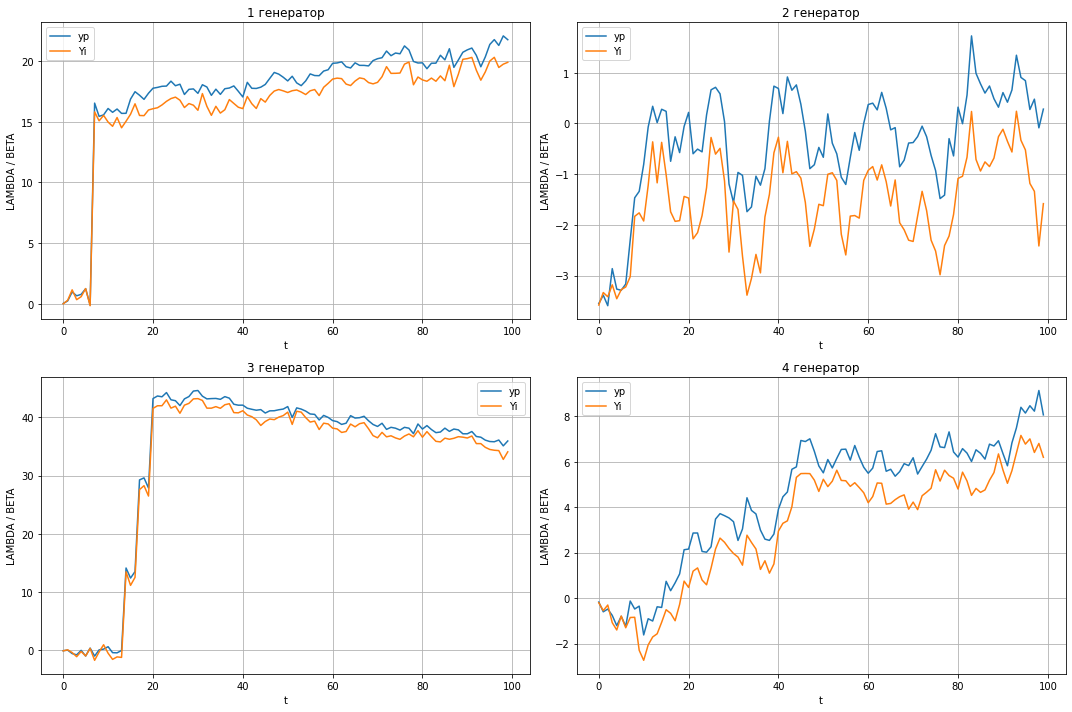

In [212]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex0_yp[0], label='yp')
plt.plot(YA[0], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex0_yp[1], label='yp')
plt.plot(YA[1], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex0_yp[2], label='yp')
plt.plot(YA[2], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex0_yp[3], label='yp')
plt.plot(YA[3], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

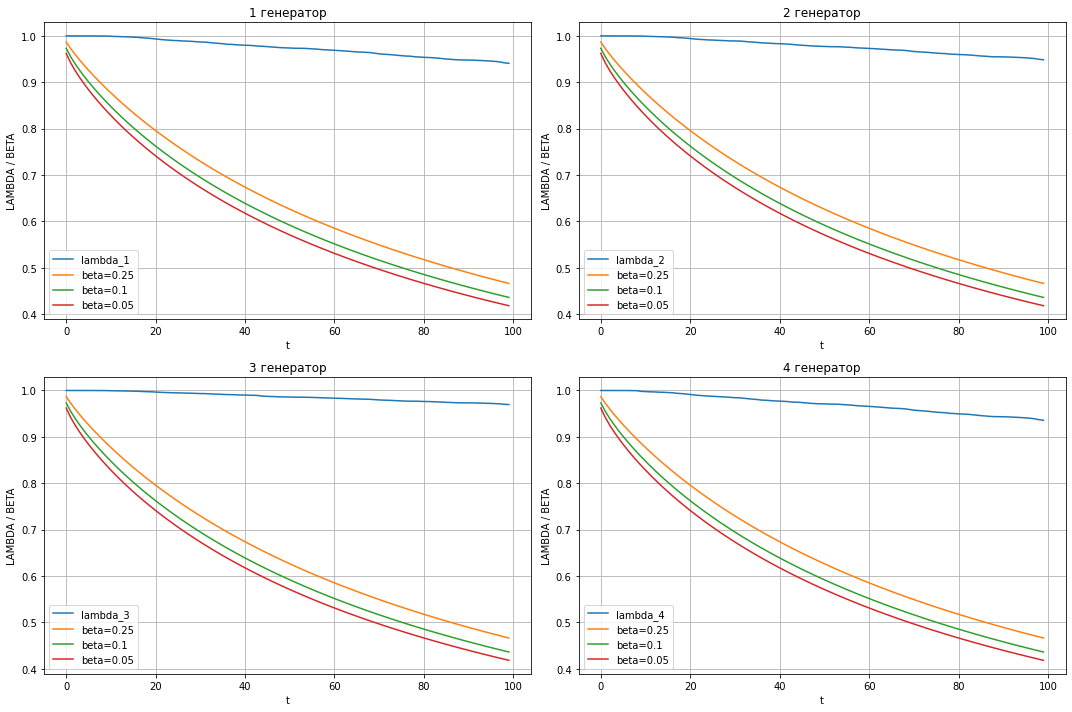

In [213]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex0_lambda[0], label='lambda_1')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex0_lambda[1], label='lambda_2')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex0_lambda[2], label='lambda_3')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex0_lambda[3], label='lambda_4')
plt.plot(ex_beta1, label='beta=0.25')
plt.plot(ex_beta2, label='beta=0.1')
plt.plot(ex_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

Оценка точности модели

In [214]:
yp_i = np.transpose(ex0_yp)
yp_sq = est(np.transpose(YA), yp_i, 100)
print(yp_sq)
# остаточная дисперсия
q_ost_yp = []
for i in range(4):
  q_ost_yp.append(yp_sq[i] / 98)

[166.2948819854782, 166.9069025564476, 168.94309041285388, 169.1584417951575]


## Эксперименты с разладкой модели

### Эксперимент 1

Загрузка данных с изменённым 1-м рядом

In [215]:
df = xl.parse('Y1') # Ряды измерений
df.head(100)
Y1 = []
for i in range(4):
    Y1.append(df['Y_' + str(i + 1)])
Z1 = create_z(Y1)

Y1 = np.transpose(Y1)
Z1 = np.transpose(Z1)

Во 1-м ряду генератора был изменён угол наклона на 0.5 с 19 такта

In [216]:
yAF1 = dynFilZ(Z1, SR_Sum, SRm * 2, len(Z1), 4)
ex1_yp = yAF1[0] #
ex1_lambda = yAF1[7] #
ex1_beta1 = yAF1[8][0] #
ex1_beta2 = yAF1[9][0] #
ex1_beta3 = yAF1[10][0] #

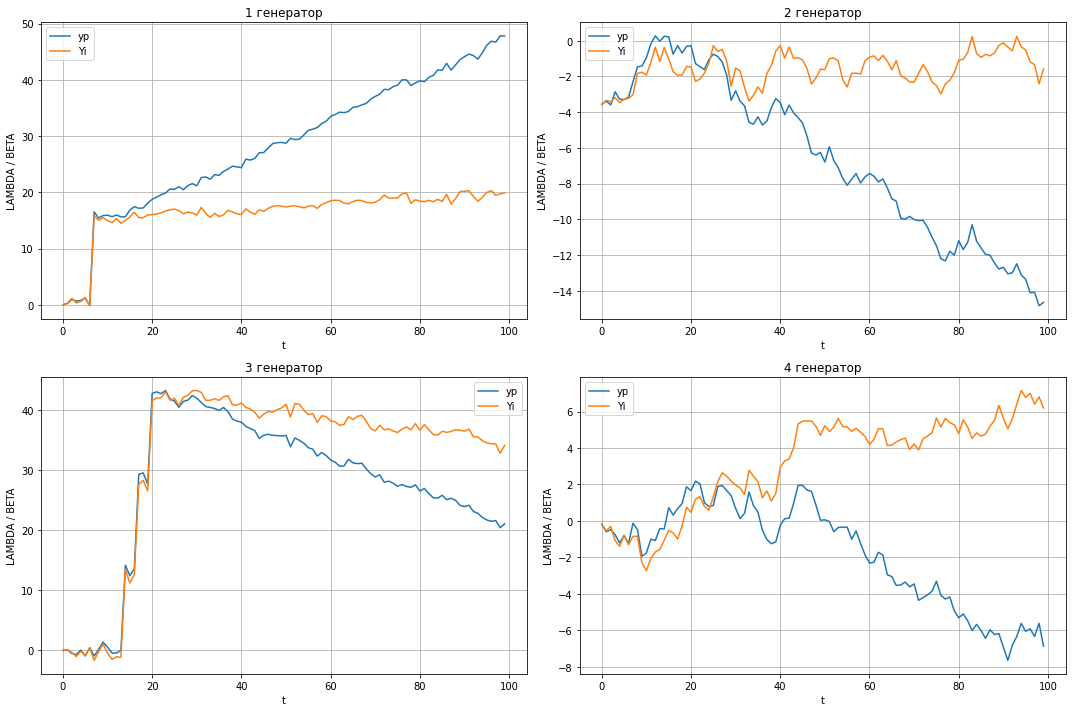

In [217]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex1_yp[0], label='yp')
plt.plot(YA[0], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex1_yp[1], label='yp')
plt.plot(YA[1], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex1_yp[2], label='yp')
plt.plot(YA[2], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex1_yp[3], label='yp')
plt.plot(YA[3], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

СРАВНЕНИЕ С РЕЗУЛЬТАТАМИ MATHCAD'А

> Генератор 1  
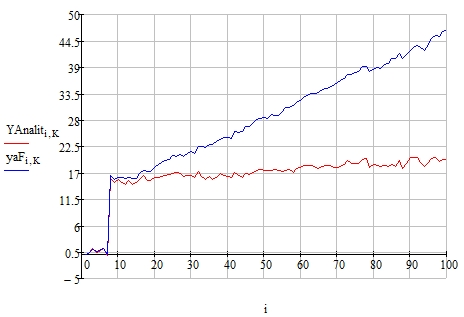

> Генератор 2  
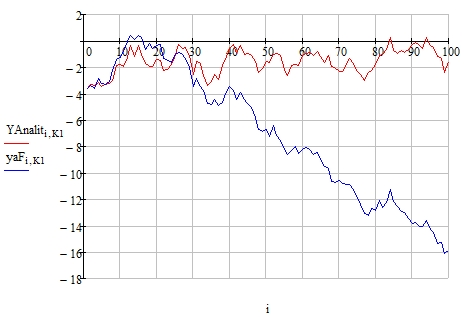

> Генератор 3  
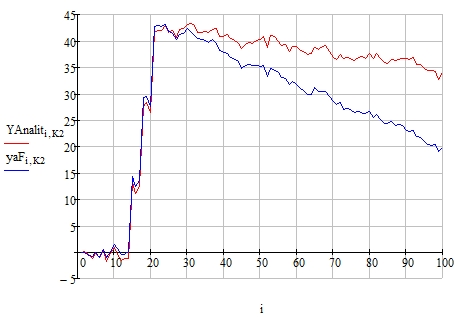

> Генератор 4  
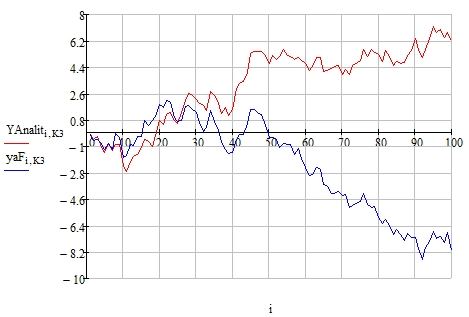

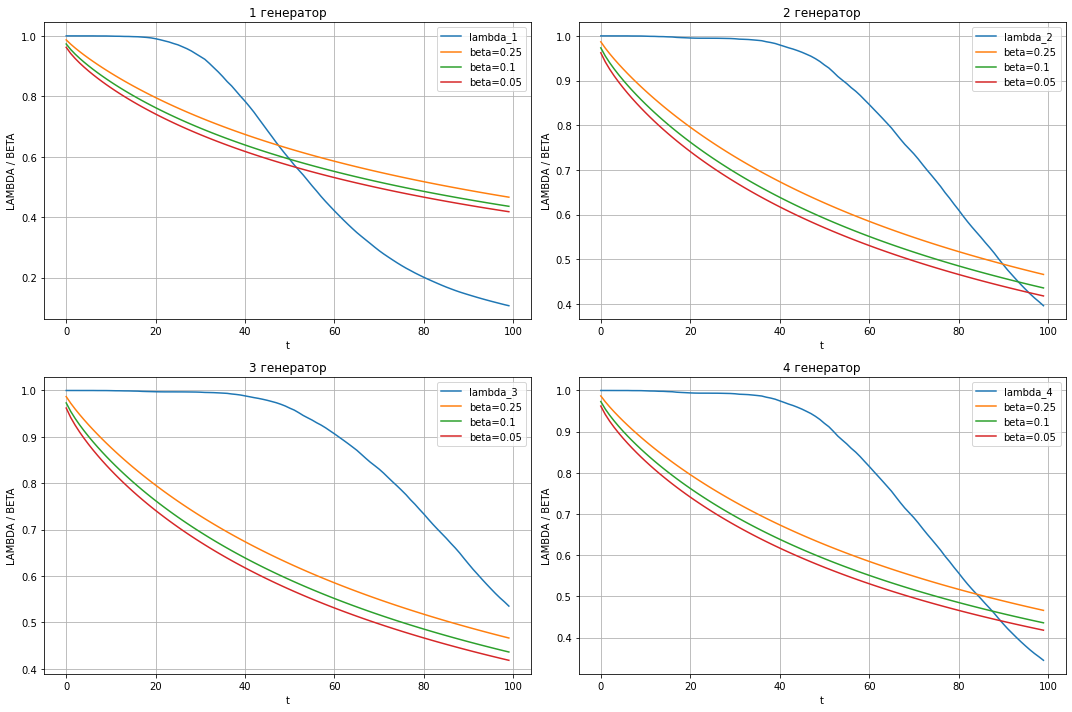

In [218]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex1_lambda[0], label='lambda_1')
plt.plot(ex1_beta1, label='beta=0.25')
plt.plot(ex1_beta2, label='beta=0.1')
plt.plot(ex1_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex1_lambda[1], label='lambda_2')
plt.plot(ex1_beta1, label='beta=0.25')
plt.plot(ex1_beta2, label='beta=0.1')
plt.plot(ex1_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex1_lambda[2], label='lambda_3')
plt.plot(ex1_beta1, label='beta=0.25')
plt.plot(ex1_beta2, label='beta=0.1')
plt.plot(ex1_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex1_lambda[3], label='lambda_4')
plt.plot(ex1_beta1, label='beta=0.25')
plt.plot(ex1_beta2, label='beta=0.1')
plt.plot(ex1_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

Оценка точности модели

In [219]:
yp1_i = np.transpose(ex1_yp)
yp1_sq = est(np.transpose(YA), yp1_i, 100)
print('оценка: ', yp1_sq)
# остаточная дисперсия
q_ost_yp1 = []
for i in range(4):
  q_ost_yp1.append(yp1_sq[i] / 98)

оценка:  [22043.51591304361, 4683.440303427739, 4683.440303427737, 4683.4403034277375]


### Эксперимент 2

Загрузка данных с изменённым 2-м рядом

In [220]:
df2 = xl.parse('Y2') # Ряды измерений
df2.head(100)
Y2 = []
for i in range(4):
    Y2.append(df2['Y_' + str(i + 1)])
Z2 = create_z(Y2)

Y2 = np.transpose(Y2)
Z2 = np.transpose(Z2)

Во 2-м ряду генератора был изменён угол наклона на 0.2 с 39 такта

In [221]:
yAF2 = dynFilZ(Z2, SR_Sum, SRm * 2, len(Z2), 4)
ex2_yp = yAF2[0] #
ex2_lambda = yAF2[7]#
ex2_beta1 = yAF2[8][0] #
ex2_beta2 = yAF2[9][0] #
ex2_beta3 = yAF2[10][0] #

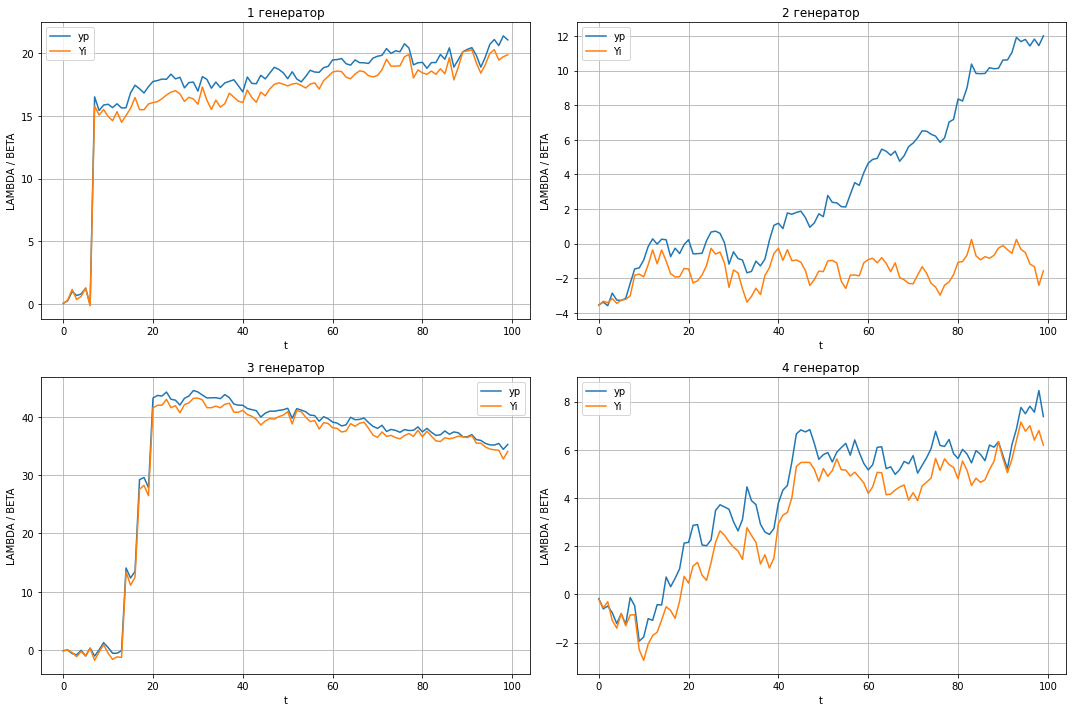

In [222]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex2_yp[0], label='yp')
plt.plot(YA[0], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex2_yp[1], label='yp')
plt.plot(YA[1], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex2_yp[2], label='yp')
plt.plot(YA[2], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex2_yp[3], label='yp')
plt.plot(YA[3], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

СРАВНЕНИЕ С РЕЗУЛЬТАТАМИ MATHCAD'А

> Генератор 1  
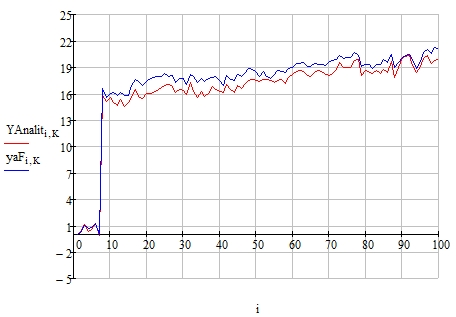

> Генератор 2  
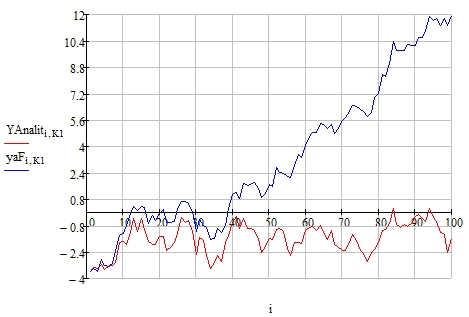

> Генератор 3  
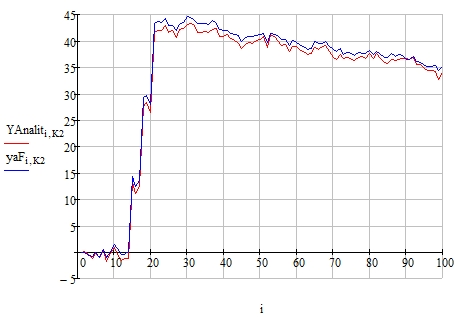

> Генератор 4  
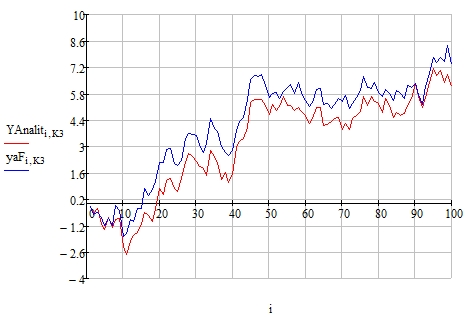

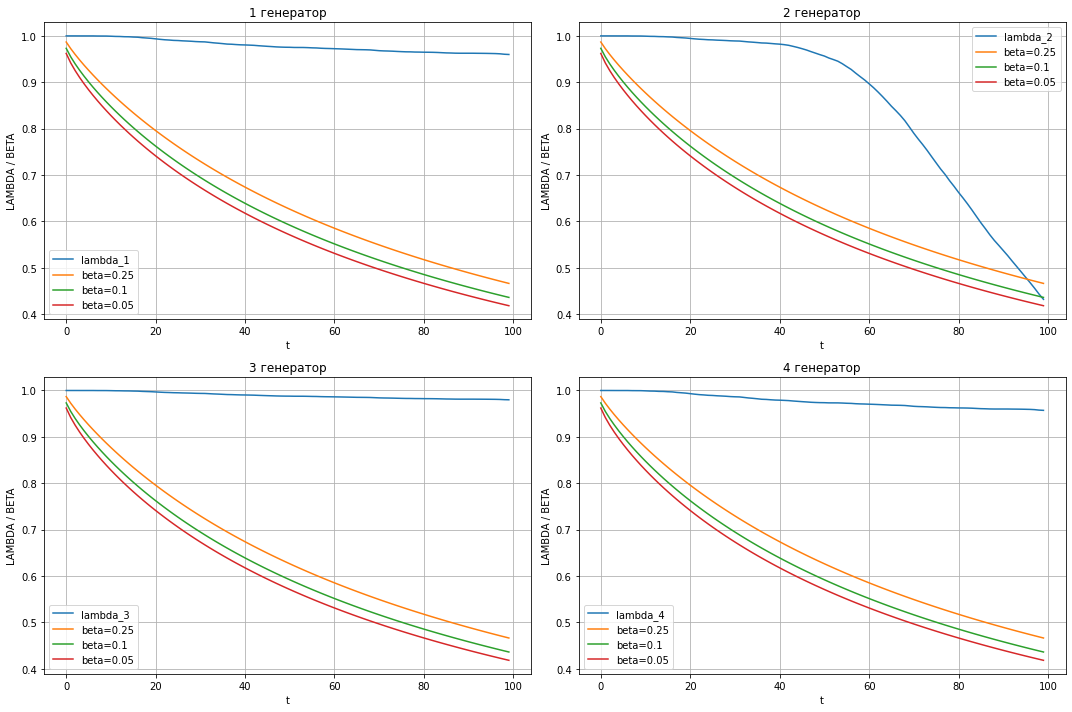

In [223]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex2_lambda[0], label='lambda_1')
plt.plot(ex2_beta1, label='beta=0.25')
plt.plot(ex2_beta2, label='beta=0.1')
plt.plot(ex2_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex2_lambda[1], label='lambda_2')
plt.plot(ex2_beta1, label='beta=0.25')
plt.plot(ex2_beta2, label='beta=0.1')
plt.plot(ex2_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex2_lambda[2], label='lambda_3')
plt.plot(ex2_beta1, label='beta=0.25')
plt.plot(ex2_beta2, label='beta=0.1')
plt.plot(ex2_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex2_lambda[3], label='lambda_4')
plt.plot(ex2_beta1, label='beta=0.25')
plt.plot(ex2_beta2, label='beta=0.1')
plt.plot(ex2_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

Оценка точности модели

In [224]:
yp2_i = np.transpose(ex2_yp)
yp2_sq = est(np.transpose(YA), yp2_i, 100)
print(yp2_sq)
# остаточная дисперсия
q_ost_yp2 = []
for i in range(4):
  q_ost_yp2.append(yp2_sq[i] / 98)

[110.3681119231151, 4044.3463684869757, 110.36811192311512, 110.36811192311514]


### Эксперимент 3

Загрузка данных с изменённым 3-м рядом

In [225]:
df = xl.parse('Y3') # Ряды измерений
df.head(100)
Y3 = []
for i in range(4):
    Y3.append(df['Y_' + str(i + 1)])
Z3 = create_z(Y3)

Y3 = np.transpose(Y3)
Z3 = np.transpose(Z3)

Во 3-м ряду генератора был изменён угол наклона на 0.7 с 49 такта

In [226]:
yAF3 = dynFilZ(Z3, SR_Sum, SRm * 2, len(Z3), 4)
ex3_yp = yAF3[0] #
ex3_lambda = yAF3[7] #
ex3_beta1 = yAF3[8][0] #
ex3_beta2 = yAF3[9][0] #
ex3_beta3 = yAF3[10][0] #

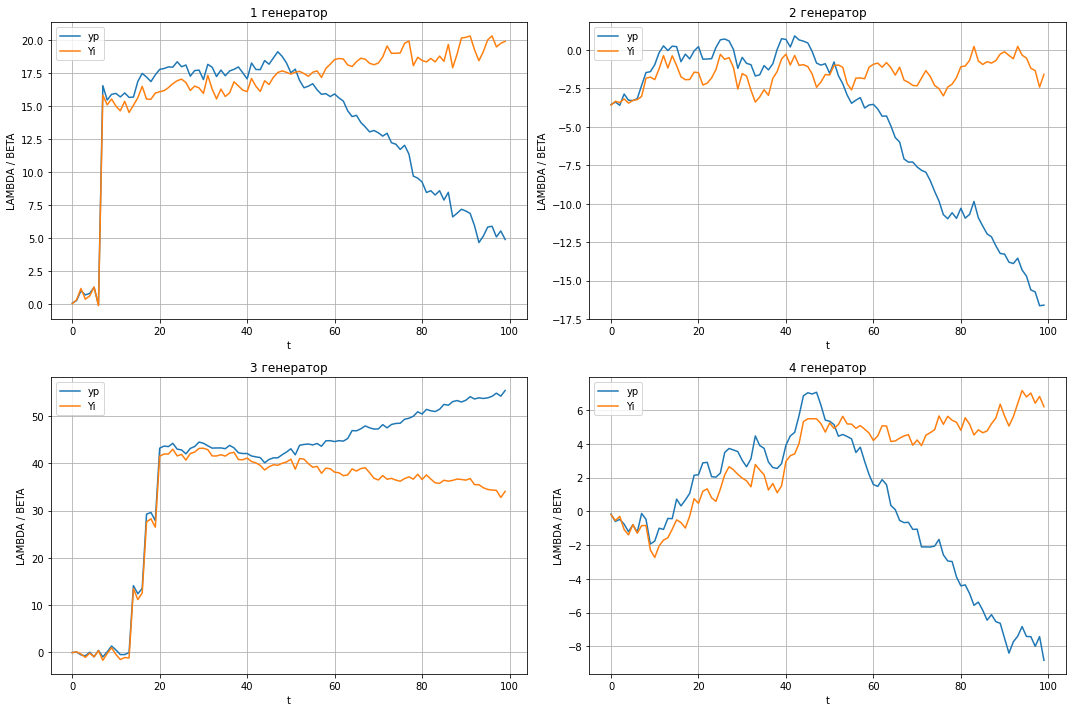

In [227]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex3_yp[0], label='yp')
plt.plot(YA[0], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex3_yp[1], label='yp')
plt.plot(YA[1], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex3_yp[2], label='yp')
plt.plot(YA[2], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex3_yp[3], label='yp')
plt.plot(YA[3], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

СРАВНЕНИЕ С РЕЗУЛЬТАТАМИ MATHCAD'А

> Генератор 1  
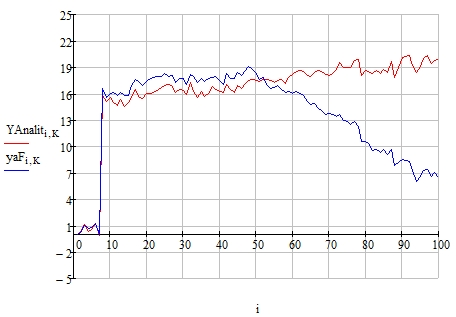

> Генератор 2  
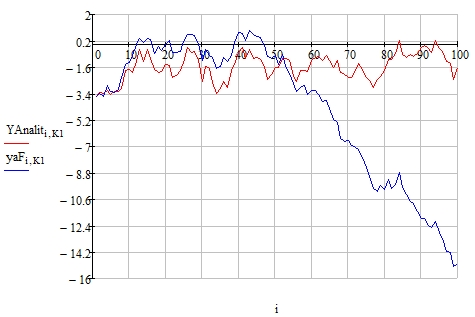

> Генератор 3  
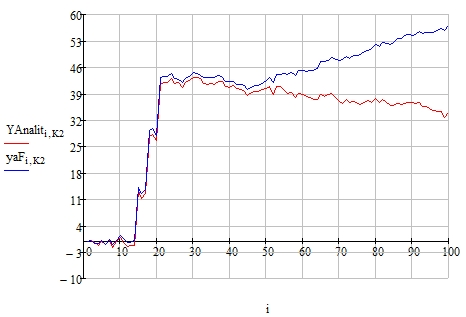

> Генератор 4  
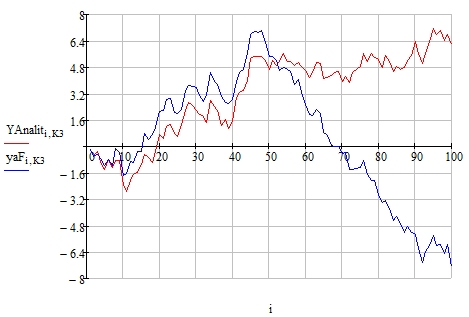

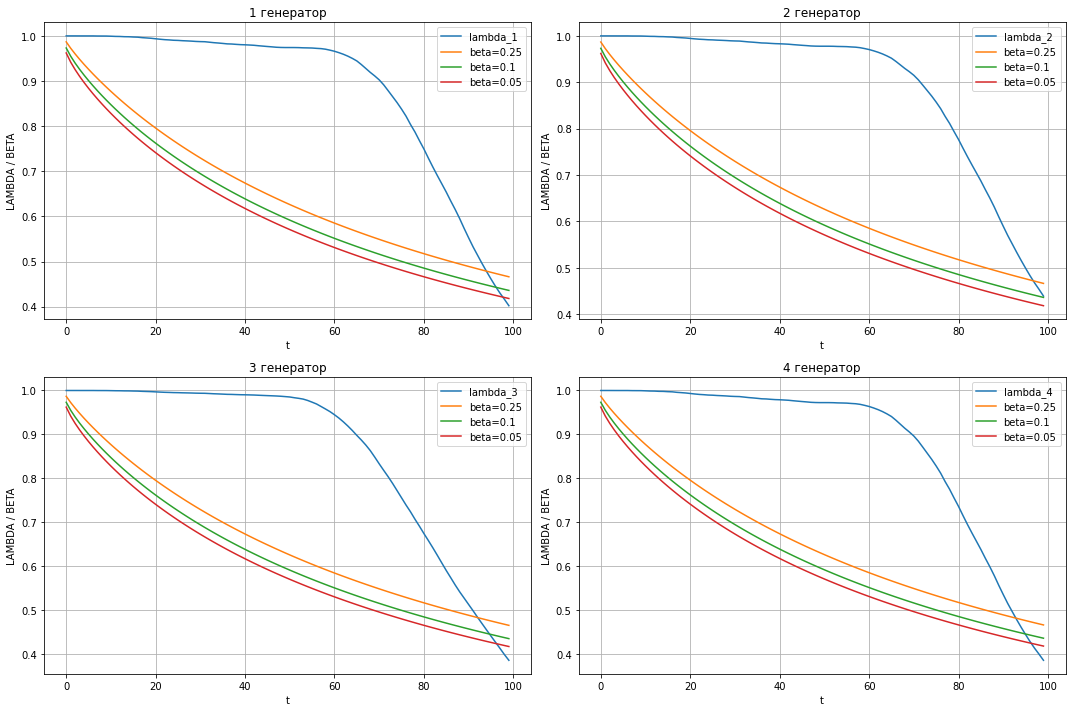

In [228]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex3_lambda[0], label='lambda_1')
plt.plot(ex3_beta1, label='beta=0.25')
plt.plot(ex3_beta2, label='beta=0.1')
plt.plot(ex3_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex3_lambda[1], label='lambda_2')
plt.plot(ex3_beta1, label='beta=0.25')
plt.plot(ex3_beta2, label='beta=0.1')
plt.plot(ex3_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex3_lambda[2], label='lambda_3')
plt.plot(ex3_beta1, label='beta=0.25')
plt.plot(ex3_beta2, label='beta=0.1')
plt.plot(ex3_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex3_lambda[3], label='lambda_4')
plt.plot(ex3_beta1, label='beta=0.25')
plt.plot(ex3_beta2, label='beta=0.1')
plt.plot(ex3_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

Оценка точности модели

In [229]:
yp3_i = np.transpose(ex3_yp)
yp3_sq = est(np.transpose(YA), yp3_i, 100)
print(yp3_sq)
# остаточная дисперсия
q_ost_yp3 = []
for i in range(4):
  q_ost_yp3.append(yp3_sq[i] / 98)

[3929.2636185376273, 3929.263618537627, 8545.623228504102, 3929.263618537627]


### Эксперимент 4

Загрузка данных с изменённым 4-м рядом

In [230]:
df = xl.parse('Y4') # Ряды измерений
df.head(100)
Y4 = []
for i in range(4):
    Y4.append(df['Y_' + str(i + 1)])
Z4 = create_z(Y4)

Y4 = np.transpose(Y4)
Z4 = np.transpose(Z4)

Во 4-м ряду генератора был изменён угол наклона на 0.3 с 9 такта

In [231]:
yAF4 = dynFilZ(Z4, SR_Sum, SRm * 2, len(Z4), 4)
ex4_yp = yAF4[0] #
ex4_lambda = yAF4[7] #
ex4_beta1 = yAF4[8][0] #
ex4_beta2 = yAF4[9][0] #
ex4_beta3 = yAF4[10][0] #

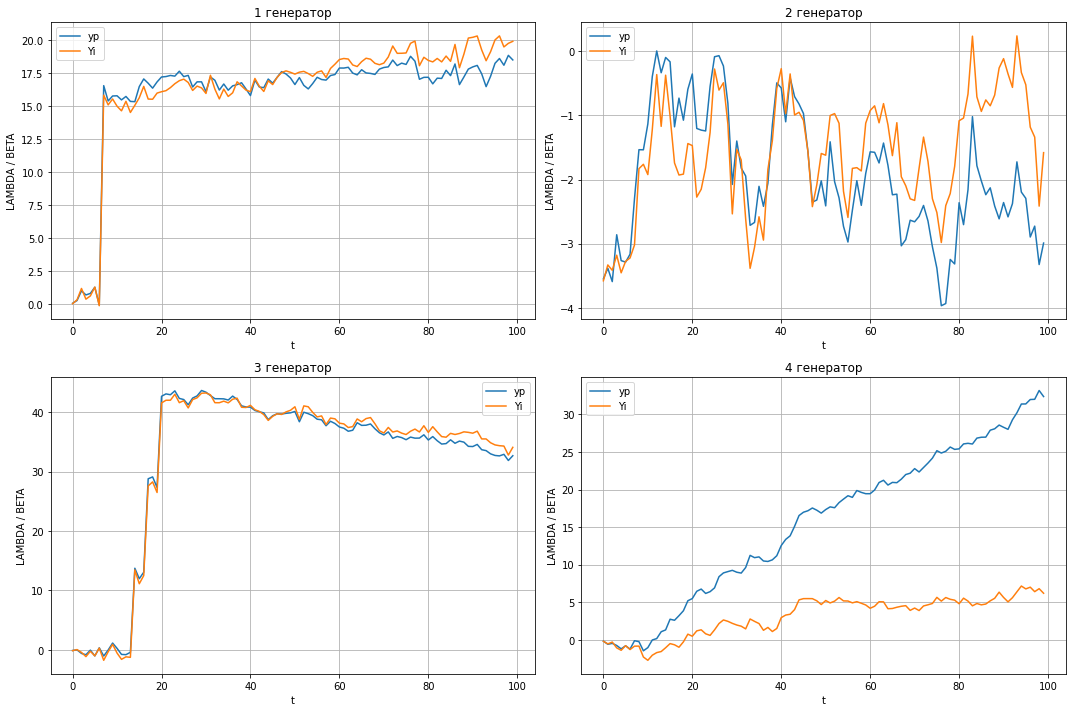

In [232]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex4_yp[0], label='yp')
plt.plot(YA[0], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex4_yp[1], label='yp')
plt.plot(YA[1], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex4_yp[2], label='yp')
plt.plot(YA[2], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex4_yp[3], label='yp')
plt.plot(YA[3], label='Yi')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

СРАВНЕНИЕ С РЕЗУЛЬТАТАМИ MATHCAD'А

> Генератор 1  
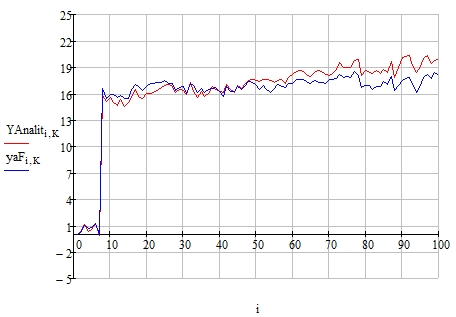

> Генератор 2  
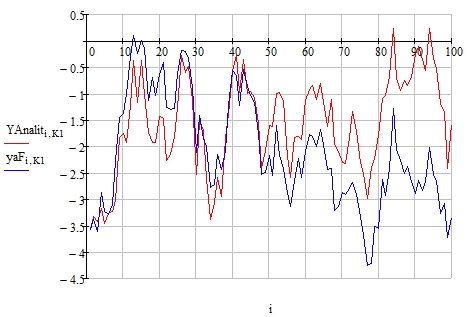

> Генератор 3  
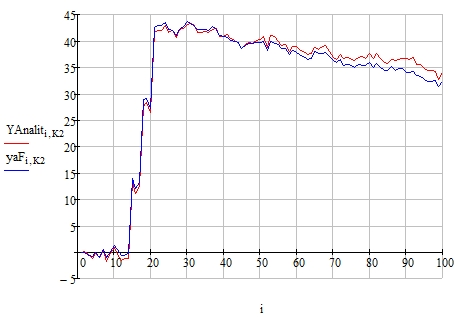

> Генератор 4  
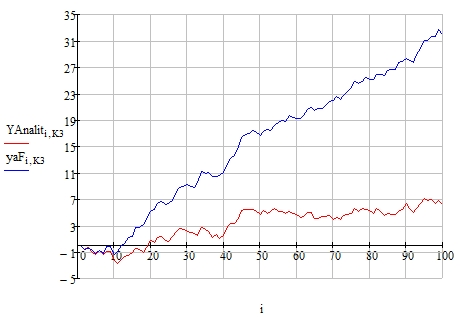

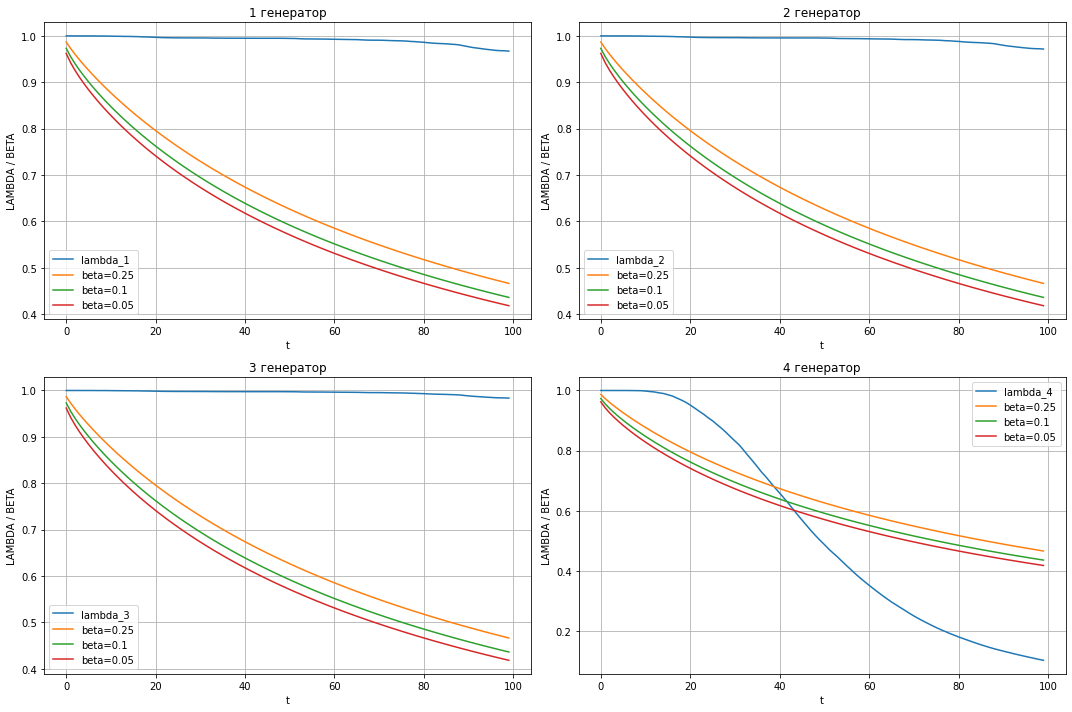

In [233]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(ex4_lambda[0], label='lambda_1')
plt.plot(ex4_beta1, label='beta=0.25')
plt.plot(ex4_beta2, label='beta=0.1')
plt.plot(ex4_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("1 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(ex4_lambda[1], label='lambda_2')
plt.plot(ex4_beta1, label='beta=0.25')
plt.plot(ex4_beta2, label='beta=0.1')
plt.plot(ex4_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("2 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(ex4_lambda[2], label='lambda_3')
plt.plot(ex4_beta1, label='beta=0.25')
plt.plot(ex4_beta2, label='beta=0.1')
plt.plot(ex4_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("3 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(ex4_lambda[3], label='lambda_4')
plt.plot(ex4_beta1, label='beta=0.25')
plt.plot(ex4_beta2, label='beta=0.1')
plt.plot(ex4_beta3, label='beta=0.05')
plt.legend(loc='best')
plt.ylabel("LAMBDA / BETA")
plt.xlabel("t")
plt.title("4 генератор")
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

Оценка точности модели

In [234]:
yp4_i = np.transpose(ex4_yp)
yp4_sq = est(np.transpose(YA), yp4_i, 100)
print(yp4_sq)
# остаточная дисперсия
q_ost_yp4 = []
for i in range(4):
  q_ost_yp4.append(yp4_sq[i] / 98)

[89.75083064215907, 89.75083064215903, 89.75083064215912, 21537.484129442222]


## СРАВНЕНИЕ ТОЧНОСТИ ОЦЕНКИ ПРОГНОЗИРУЮЩИХ МОДЕЛЕЙ ЭКСПЕРИМЕНТОВ

In [235]:
print("---------------------------------------------------------------------------------")
print("|     1 генератор     |     2 генератор     |     3 генератор     |     4 генератор     |")
print("---------------------------------------------------------------------------------")
print(q_ost_yp, "эксперимент без разладки")
print("---------------------------------------------------------------------------------")
print(q_ost_yp1, "эксперимент 1")
print("---------------------------------------------------------------------------------")
print(q_ost_yp2, "эксперимент 2")
print("---------------------------------------------------------------------------------")
print(q_ost_yp3, "эксперимент 3")
print("---------------------------------------------------------------------------------")
print(q_ost_yp4, "эксперимент 4")
print("---------------------------------------------------------------------------------")

---------------------------------------------------------------------------------
|     1 генератор     |     2 генератор     |     3 генератор     |     4 генератор     |
---------------------------------------------------------------------------------
[1.6968865508722266, 1.703131658739261, 1.7239090858454478, 1.7261065489301786] эксперимент без разладки
---------------------------------------------------------------------------------
[224.9338358473838, 47.79020717783408, 47.79020717783405, 47.790207177834056] эксперимент 1
---------------------------------------------------------------------------------
[1.126205223705256, 41.26884049476506, 1.1262052237052564, 1.1262052237052564] эксперимент 2
---------------------------------------------------------------------------------
[40.09452671977171, 40.0945267197717, 87.20023702555207, 40.0945267197717] эксперимент 3
---------------------------------------------------------------------------------
[0.915824802471011, 0.9158248024710105,